<img align="center" src="./images/occiput_logo3.png" width="400">

# Simulator of Siemens Biograph mMR PET-MR scanner

#### This notebook shows how to simulate PET acquisition and reconstruction using the Siemens Biograph mMR geometry  

# SIMULATION

In [1]:
import occiput
from occiput.Reconstruction.PET.PET_scanners import Biograph_mMR

import numpy as np
import scipy.io as io

In [2]:
sim_path = '../../Douglas/simulation/01'

## Set scanner geometry and characteristics

In [3]:
pet = occiput.Reconstruction.PET.PET_Static_Scan()
pet.set_scanner(Biograph_mMR) 

In [4]:
pet.use_compression(False) 

In [5]:
pet.import_sensitivity('%s/norm3d_00.h33'%sim_path) 

## Load activity phantom and attenuation phantom

#### Change the files here to change groundtruth activity and attenuation. Or change the variable simulation_path; in this case the new path must contains the required nifti files with the activity and attenuation phantoms. 

In [6]:
true_activity = occiput.DataSources.FileSources.import_nifti('%s/true_activity.nii'%sim_path)
attenuation   = occiput.DataSources.FileSources.import_nifti('%s/attenuation.nii'%sim_path)

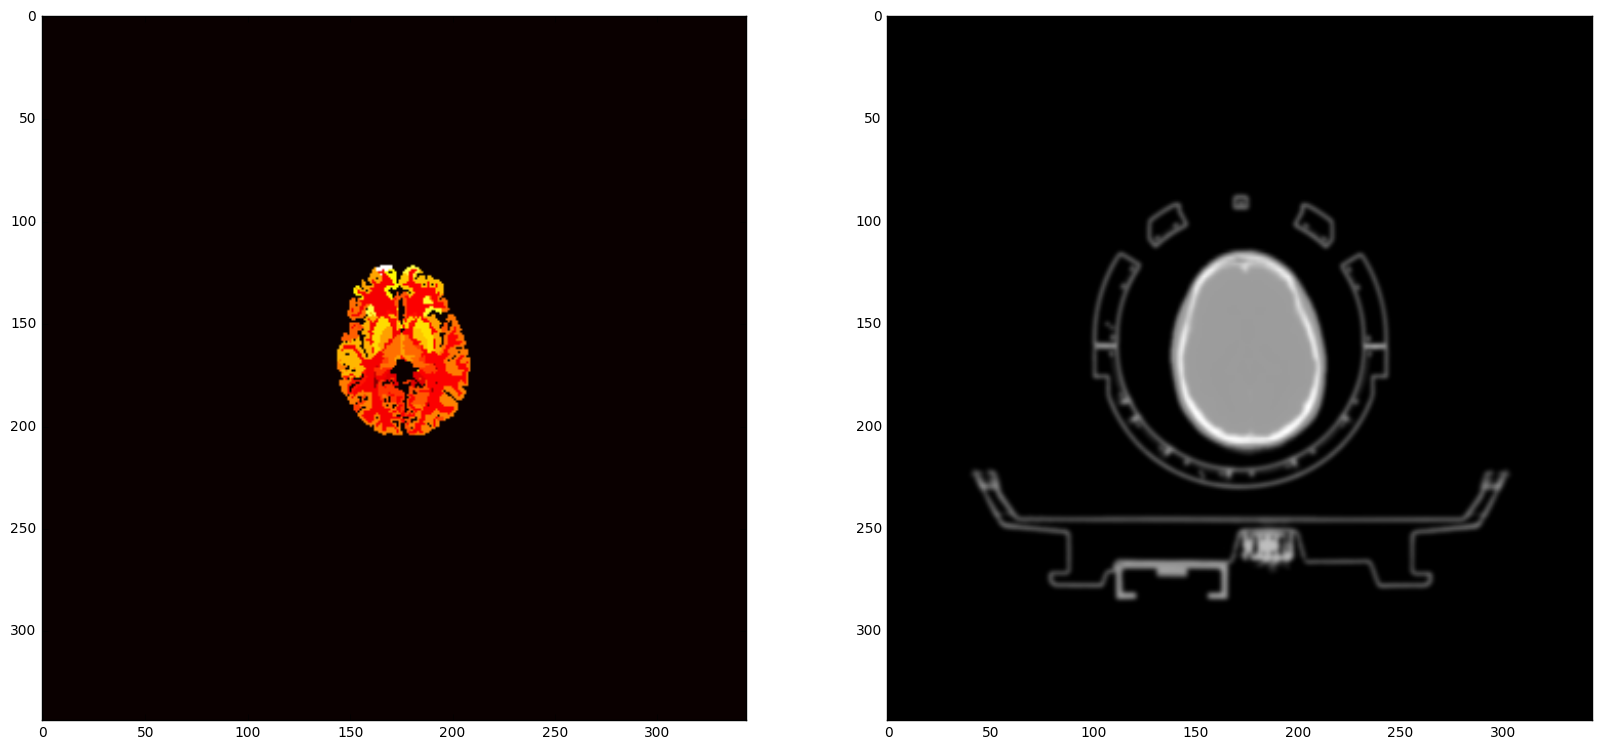

In [7]:
figure(figsize=[20,10])
subplot(1,2,1); imshow(flipud(true_activity.data[:,:,64]),cmap='hot') 
subplot(1,2,2); imshow(flipud(attenuation.data[:,:,64]),cmap='gray') 

## Simulate PET acquisition

#### 1- Compute noiseless prompts in the ideal case (no scatter, no randoms)

In [8]:
# Set the discretization grid for the attenuation:
pet.set_attenuation_shape([344,344,127])
pet.set_attenuation_size([2.08626*344, 2.08626*344, 2.03125*127])
attenuation_projection = pet.project_attenuation(attenuation)

# Set the discretization grid for the activity: 
pet.set_activity_shape([344,344,127])
pet.set_activity_size([2.08626*344, 2.08626*344, 2.03125*127])
ideal_prompts = pet.project_activity(true_activity) 

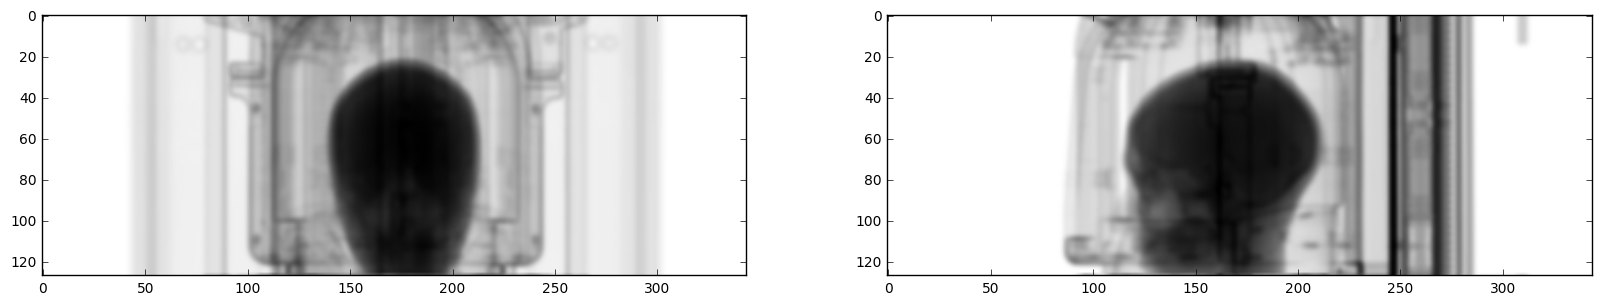

In [9]:
figure(figsize=[20,10])
subplot(1,2,1); imshow(flipud(attenuation_projection.to_nd_array()[0,5,:,:].T), cmap="gray")
subplot(1,2,2); imshow(flipud(attenuation_projection.to_nd_array()[126,5,:,:].T), cmap="gray")

#### 2- Add expected randoms and scatter 

In [10]:
randoms = occiput.DataSources.FileSources.import_PET_Projection('%s/randoms.h5'%sim_path)
scatter = occiput.DataSources.FileSources.import_PET_Projection('%s/scatter.h5'%sim_path)

#### 3- Set scan duration and apply Poisson noise

In [11]:
acquisition_time_sec = 20*60
counts_per_sec       = 5e5

scale = acquisition_time_sec * counts_per_sec / ideal_prompts.data.sum()

randoms.data = randoms.data * scale
scatter.data = 10*scatter.data * scale 

import copy
prompts = copy.deepcopy(ideal_prompts)
prompts.data = ideal_prompts.data * scale * attenuation_projection.data * pet.sensitivity.data + randoms.data + scatter.data * pet.sensitivity.data

noisy_prompts = copy.deepcopy(prompts)
noisy_prompts.data = numpy.random.poisson(prompts.data)

print true_activity.data.max(), true_activity.data.mean()
print scale
print pet.scale_activity

7.69617 0.0355924
0.195925829482
3.432e-05


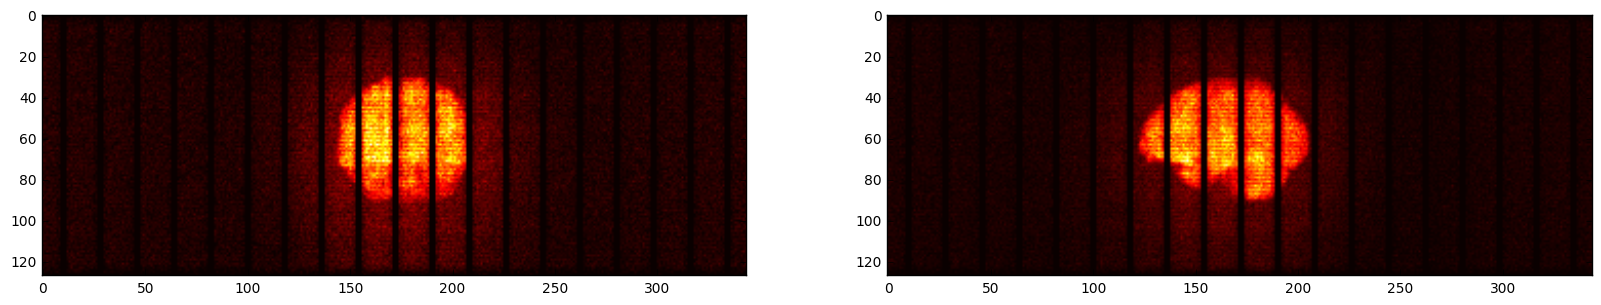

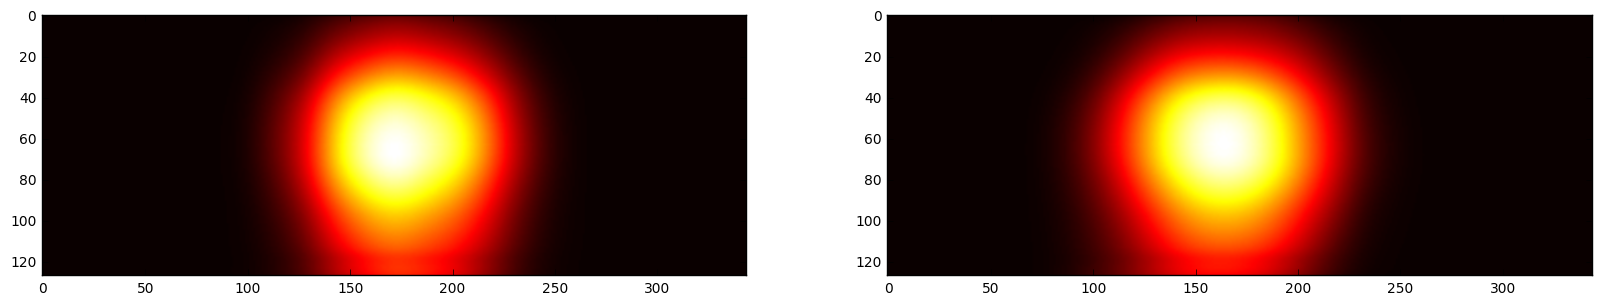

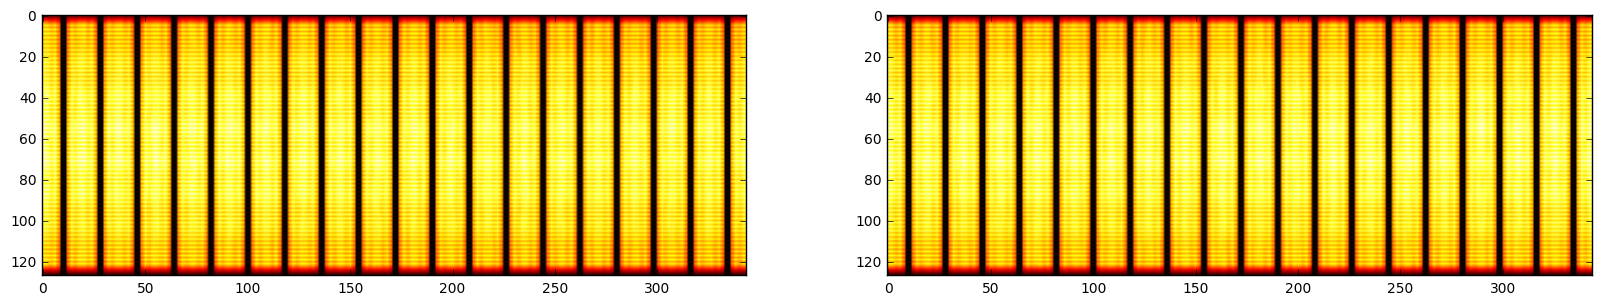

In [12]:
figure(figsize=[20,10])
subplot(1,2,1); imshow(flipud(noisy_prompts.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(noisy_prompts.to_nd_array()[126,5,:,:].T), cmap="hot")
figure(figsize=[20,10])
subplot(1,2,1); imshow(flipud(scatter.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(scatter.to_nd_array()[126,5,:,:].T), cmap="hot")
figure(figsize=[20,10])
subplot(1,2,1); imshow(flipud(randoms.to_nd_array()[0,5,:,:].T), cmap="hot")
subplot(1,2,2); imshow(flipud(randoms.to_nd_array()[126,5,:,:].T), cmap="hot")

## Reconstruct

In [13]:
#pet.set_prompts(ideal_prompts) 
pet.set_prompts(noisy_prompts) 
pet.set_randoms(randoms) 
pet.set_scatter(scatter) 
pet.set_attenuation(attenuation)

pet.scale_activity = 1.0

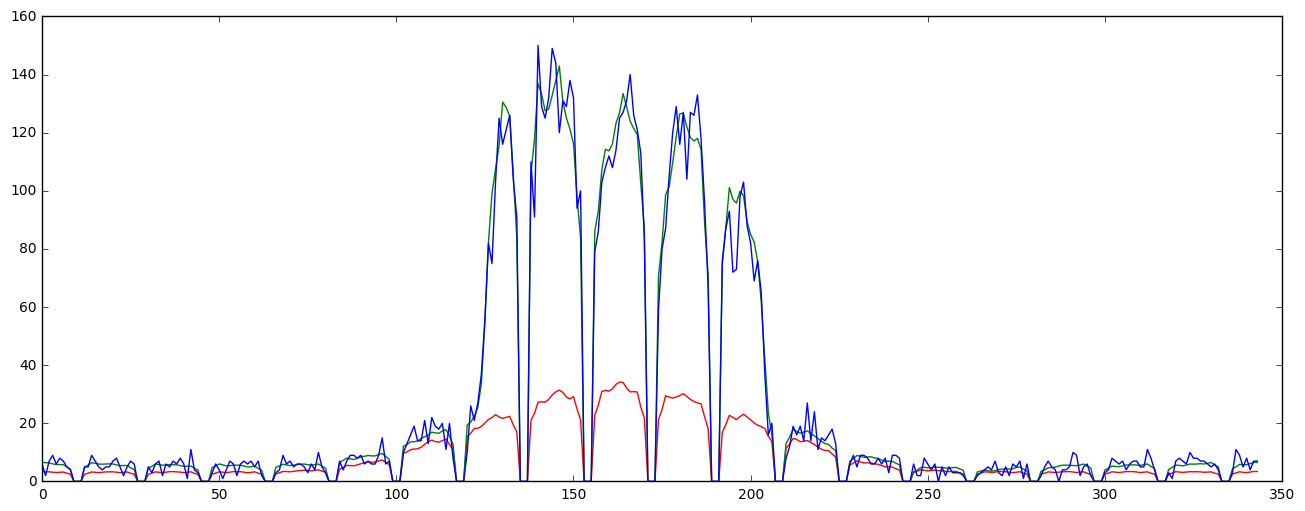

In [14]:
figure(figsize=[16,6]); hold(1)
plot(pet.randoms.data[126,8,:,70] + pet.scatter.data[126,8,:,70]*pet.sensitivity.data[126,5,:,70],'r'); 
plot(prompts.data[126,8,:,70],'g');
plot(pet.prompts.data[126,8,:,70],'b');

In [15]:
Nx = 128
Ny = 128
Nz = 128
pet.set_activity_shape([Nx,Ny,Nz])
pet.set_activity_size([2.08626*Nx, 2.08626*Ny, 2.03125*Nz])

In [16]:
# Free some memory
del ideal_prompts, prompts, attenuation

In [17]:
activity = pet.osem_reconstruction(iterations=15, subset_mode="ordered_axial", subset_size=12, attenuation_projection=attenuation_projection) 

0


KeyboardInterrupt: 

In [ ]:
figure(figsize=[20,10]) 
subplot(1,3,1); imshow(flipud(true_activity.data[:,:,64]),cmap='hot') 
subplot(1,3,2); imshow(flipud(activity.data[:,:,64]),cmap='hot') 
subplot(1,3,3); imshow(flipud(attenuation.data[:,:,64]),cmap='gray') 

In [ ]:
pet.prompts.save_to_file('%s/noisy_prompts.nii'%sim_path) 
activity.save_to_file('%s/activity_recon.nii'%sim_path) 

In [ ]:
figure(figsize=[20,6])
subplot(1,2,1); plot(activity.data[170,:,64]*pet.scale_activity/scale); hold(1); plot(true_activity.data[170,:,64]);
print true_activity.data.max(), true_activity.data.mean()
print activity.data.max()*pet.scale_activity/scale, activity.data.mean()*pet.scale_activity/scale